In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install keras matplotlib nltk numpy scikit-learn seaborn

In [ ]:
pip install tensorflow

   ---------------------------------------- 0.0/390.3 MB ? eta -:--:--
   ---------------------------------------- 1.6/390.3 MB 9.3 MB/s eta 0:00:42
   ---------------------------------------- 2.9/390.3 MB 12.0 MB/s eta 0:00:33
    --------------------------------------- 6.3/390.3 MB 11.7 MB/s eta 0:00:33
   - -------------------------------------- 10.7/390.3 MB 13.4 MB/s eta 0:00:29
   - -------------------------------------- 13.6/390.3 MB 14.0 MB/s eta 0:00:27
   - -------------------------------------- 16.5/390.3 MB 13.7 MB/s eta 0:00:28
   -- ------------------------------------- 21.0/390.3 MB 14.9 MB/s eta 0:00:25
   -- ------------------------------------- 23.6/390.3 MB 14.8 MB/s eta 0:00:25
   -- ------------------------------------- 26.2/390.3 MB 14.3 MB/s eta 0:00:26
   -- ------------------------------------- 29.1/390.3 MB 14.3 MB/s eta 0:00:26
   --- ------------------------------------ 33.3/390.3 MB 14.7 MB/s eta 0:00:25
   --- ------------------------------------ 36.2/390.

In [ ]:
import tensorflow as tf
from tensorflow.keras import Model, layers, Input
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pickle

# --- Configuración Inicial ---
vocab_size = 25000  # Tamaño del vocabulario
embedding_dim = 300  # Dimensión del embedding
sequence_length = 400  # Longitud máxima de secuencias
latent_dim = 128  # Dimensión del espacio latente
batch_size = 32
epochs = 10
num_classes = 2  # Clasificación binaria

In [ ]:
# Cargar el archivo pickle
with open(r'C:\Users\mstor\Downloads\Dataset\vocabulario_new_50_ngrams.pickle', 'rb') as f:
    vocabulario = pickle.load(f)

# Comprobar que se cargó correctamente
print("Tamaño del vocabulario:", len(vocabulario))

Tamaño del vocabulario: 10000


In [ ]:
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower()
    text = ''.join([char for char in text if char not in string.punctuation])
    #text = ' '.join([word for word in text.split() if word not in stop_words])

    # Lematizar palabras especificando el POS
    #text = ' '.join([lemmatizer.lemmatize(word, pos='v') for word in text.split()])  # Lematizar como verbos
    return text


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mstor\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mstor\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
from tensorflow.keras.layers import TextVectorization

# Crear el vectorizador basado en el vocabulario cargado
vectorizador = TextVectorization(output_mode='int', vocabulary=vocabulario)

In [ ]:
from tensorflow.keras.saving import register_keras_serializable
import tensorflow as tf
from tensorflow.keras import Model, layers, Input
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# --- Ajustes del optimizador ---
initial_lr = 1e-4  # Tasa de aprendizaje reducida
optimizer = Adam(learning_rate=initial_lr)

# --- Callbacks para mejorar convergencia ---
lr_scheduler = ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6, verbose=1
)
early_stopping = EarlyStopping(
    monitor="val_loss", patience=10, restore_best_weights=True, verbose=1
)

# --- Definición del Encoder ---
encoder_inputs = Input(shape=(sequence_length,), name="encoder_input")
x = vectorizador(encoder_inputs)
x = tf.keras.layers.Embedding(vocab_size, embedding_dim, mask_zero=True, name="embedding_layer")(encoder_inputs)  # Embeddingç
x = layers.LSTM(sequence_length, return_sequences=False, use_cudnn=False, kernel_regularizer=regularizers.l2(0.01), name="encoder_lstm")(x)  # Reducimos unidades en LSTM y agregamos regularización L2
x = layers.Dense(256, activation="relu", kernel_regularizer=regularizers.l2(0.01), name="encoder_dense_1")(x)  # Regularización L2
x = layers.Dropout(0.4)(x)  # Dropout para prevenir overfitting
x = layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(0.01), name="encoder_dense_2")(x)  # Regularización L2

# Parametrización de la distribución latente
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

# Reparametrización
def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.keras.backend.random_normal(shape=(tf.shape(z_mean)[0], latent_dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = layers.Lambda(sampling, name="z_sampling")([z_mean, z_log_var])

encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

# --- Definición del Decoder ---
decoder_inputs = Input(shape=(latent_dim,), name="z_sampling_input")
x = layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(0.01), name="decoder_dense")(decoder_inputs)  # Regularización L2
x = layers.Dense(256, activation="relu", kernel_regularizer=regularizers.l2(0.01), name="decoder_dense_1")(x)  # Regularización L2
x = layers.RepeatVector(sequence_length)(x)
decoder_outputs = layers.LSTM(sequence_length, return_sequences=True, kernel_regularizer=regularizers.l2(0.01))(x)  # Regularización L2
decoder_outputs = layers.TimeDistributed(layers.Dense(vocab_size, activation="softmax"))(decoder_outputs)
decoder = Model(decoder_inputs, decoder_outputs, name="decoder")


# --- Definición del Autoencoder ---
vae_outputs = decoder(encoder(encoder_inputs)[2])

def vae_loss(inputs, outputs, z_mean, z_log_var):
    # Reconstrucción: sparse crossentropy acepta inputs enteros directamente
    reconstruction_loss = tf.reduce_mean(
        tf.keras.losses.sparse_categorical_crossentropy(inputs, outputs)
    )

    # KL Divergence ajustada para evitar sumas grandes
    kl_loss = -0.5 * tf.reduce_mean(
        1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
    )
    beta = 0.4  # Hiperparámetro de ajuste
    return reconstruction_loss + beta * kl_loss

def custom_mse(y_true, y_pred):
    y_pred = tf.argmax(y_pred, axis=-1)  # Obtener los tokens con mayor probabilidad

    # Convertir a enteros
    y_pred = tf.cast(y_pred, tf.int32)  # Convertir y_pred a tf.int32

    # Calcular MSE solo en la dimensión de la secuencia
    mse = tf.keras.losses.MeanSquaredError()(y_true, y_pred)

    return mse

# --- Definición del modelo con `train_step` personalizado ---
from tensorflow.keras.metrics import MeanSquaredError
@register_keras_serializable()
class VAEModel(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAEModel, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        return self.decoder(z), z_mean, z_log_var
        #return self.decoder(z)

    def get_config(self):
        config = super().get_config()
        config.update({
            "encoder": self.encoder,
            "decoder": self.decoder
        })
        return config

    @classmethod
    def from_config(cls, config):
        encoder = config.pop("encoder")
        decoder = config.pop("decoder")
        return cls(encoder, decoder, **config)

    def train_step(self, data):
        self.reset_metrics()  # Reinicia las métricas antes de cada paso
        with tf.GradientTape() as tape:
            inputs = data
            outputs, z_mean, z_log_var = self(inputs, training=True)
            loss = vae_loss(inputs, outputs, z_mean, z_log_var)

        # Computar gradientes
        grads = tape.gradient(loss, self.trainable_variables)

        # Actualizar los pesos
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        mse=custom_mse(inputs, outputs)

        return {"loss": loss, "custom_mse": mse}  # Cambiar el nombre de la métrica en el diccionario de salida

    def test_step(self, data):
        self.reset_metrics()  # Reinicia las métricas antes del paso de prueba
        inputs = data
        outputs, z_mean, z_log_var = self(inputs, training=False)
        loss = vae_loss(inputs, outputs, z_mean, z_log_var)

        mse=custom_mse(inputs, outputs)
        return {"loss": loss, "custom_mse": mse}  # Cambiar el nombre de la métrica en el diccionario de salida

from tensorflow.keras.callbacks import LearningRateScheduler

def print_lr(epoch, lr):
    print(f"Epoch: {epoch + 1}, Learning Rate: {lr}")

lr_callback = LearningRateScheduler(lambda epoch, lr: lr, verbose=1)
# Crear el modelo VAE
vae_model = VAEModel(encoder, decoder)

In [ ]:

import tensorflow as tf
import pickle
from tensorflow.keras.saving import register_keras_serializable
from tensorflow.keras.models import load_model

custom_objects = {
    "VAEModel": VAEModel,
}

vae_model = tf.keras.models.load_model(
   r'C:\Users\mstor\Downloads\Dataset\mi_modelo_vae_new_50_ngrams.keras',
    custom_objects={"VAEModel": VAEModel, "vae_loss": vae_loss}
)

# Cargar el historial de entrenamiento
with open(r'C:\Users\mstor\Downloads\Dataset\history_new_50_ngrams.pickle', 'rb') as f:
    history = pickle.load(f)

# Cargar el optimizador (si es necesario)
with open(r'C:\Users\mstor\Downloads\Dataset\optimizer_new_50_ngrams.pickle', 'rb') as f:
    optimizer_state = pickle.load(f)
    vae_model.compile(optimizer=optimizer_state)


C:\Users\mstor\miniconda3\Lib\site-packages\keras\src\saving\serialization_lib.py:730: UserWarning: Model 'vae_model' had a build config, but the model cannot be built automatically in `build_from_config(config)`. You should implement `def build_from_config(self, config)`, and you might also want to implement the method  that generates the config at saving time, `def get_build_config(self)`. The method `build_from_config()` is meant to create the state of the model (i.e. its variables) upon deserialization.
  instance.build_from_config(build_config)
C:\Users\mstor\miniconda3\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 44 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:

from tensorflow.keras.preprocessing.sequence import pad_sequences

contador = 0
def obtener_representacion_latente(texto):
    global contador
    contador += 1
    print(f"Procesando documento {contador}")
    # 1. Preprocesar el texto
    texto_preprocesado = preprocess_text(texto)

    # 1. Vectorizar el texto
    secuencia = vectorizador([texto_preprocesado]).numpy()[0]

    # 2. Rellenar o truncar la secuencia
    secuencia_rellenada = pad_sequences([secuencia], maxlen=sequence_length, padding='post', truncating='post')

    # 3. Obtener la representación latente
    z_mean, _, _ = encoder.predict(secuencia_rellenada)

    return z_mean

texto = "principal decided students must participate least one extracurricular activity example students could participate sports work yearbook serve student council agree disagree decision decision principal come brilliant beneficial students students finally fun thing look forward wake morning go school instead dreading students involved least one extracurricular activity might find new skill may hidden way bring potential extracurricular something productive"



C:\Users\mstor\Downloads\Dataset\train_drcat_01.csv
C:\Users\mstor\Downloads\Dataset\train_drcat_02.csv
C:\Users\mstor\Downloads\Dataset\train_drcat_03.csv
C:\Users\mstor\Downloads\Dataset\train_drcat_04.csv


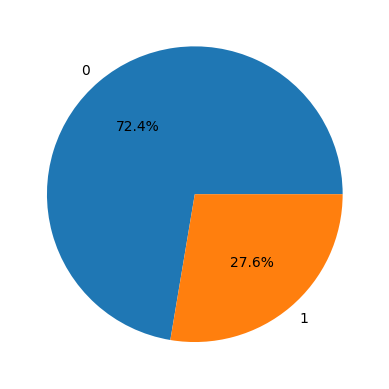

In [ ]:
# Define la ruta a la carpeta
ruta_carpeta = 'C:\\Users\\mstor\\Downloads\\Dataset\\'

# Define los nombres de los archivos
nombres_archivos = ['train_drcat_01.csv', 'train_drcat_02.csv', 'train_drcat_03.csv', 'train_drcat_04.csv']
# Crea una lista vacía para almacenar los DataFrames
dfs = []

# Itera sobre los nombres de los archivos y lee cada uno en un DataFrame
for nombre_archivo in nombres_archivos:
    ruta_archivo = ruta_carpeta + nombre_archivo
    print(ruta_archivo)
    df = pd.read_csv(ruta_archivo, sep=",", encoding='utf-8')  # Ajusta el separador y la codificación si es necesario
    dfs.append(df)

# Concatena todos los DataFrames en uno solo
df_final = pd.concat(dfs, ignore_index=True)

# Mostramos las 5 primeras filas
df_final.head()

plt.pie(df_final['label'].value_counts().values,
        labels = df_final['label'].value_counts().index,
        autopct='%1.1f%%')
plt.show()

In [ ]:
print(df_final['label'].value_counts())

label
0    115372
1     44084
Name: count, dtype: int64


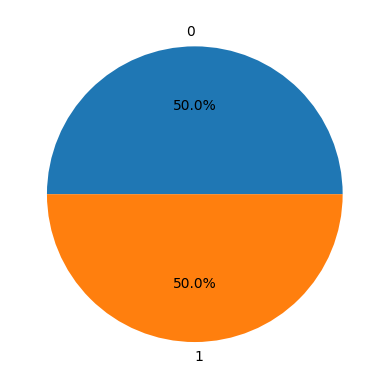

In [ ]:
df_label_0 = df_final[df_final['label'] == 0].sample(n=40000, random_state=42)  # random_state para reproducibilidad

# Seleccionar 1000 textos con label 1
df_label_1 = df_final[df_final['label'] == 1].sample(n=40000, random_state=42)

# Concatenar los dos DataFrames
df_seleccionado = pd.concat([df_label_0, df_label_1])

# Reiniciar el índice
df_seleccionado = df_seleccionado.reset_index(drop=True)

plt.pie(df_seleccionado['label'].value_counts().values,
        labels = df_seleccionado['label'].value_counts().index,
        autopct='%1.1f%%')
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras import Model, layers, Input
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Configuración Inicial ---
embedding_dim = 300  # Dimensión del embedding
sequence_length = 400  # Longitud máxima de secuencias
latent_dim = 128  # Dimensión del espacio latente
batch_size = 32
epochs = 20


# --- Carga y Preprocesamiento de Datos ---
df=df_seleccionado

In [ ]:
# Eliminar registros nulos o vacíos en la columna de texto
df = df.dropna(subset=["text"])
df = df[df["text"].str.strip() != ""]
df['text_clean'] = df['text'].apply(preprocess_text)

In [ ]:
df.head()

,text,label,source,fold,essay_id,prompt,text_clean
0,Your principal has decided that all students m...,0,persuade_corpus,8,E50212D4B912,NaN,your principal has decided that all students m...
1,I think that people ask more than one person f...,0,persuade_corpus,2,NaN,NaN,i think that people ask more than one person f...
2,Dear Principle\n\nI have heard about your deci...,0,persuade_corpus,1,NaN,NaN,dear principle\n\ni have heard about your deci...
3,Driverless Cars: Where are They?\n\nDriverless...,0,persuade_corpus,2,8AE833D4B9F8,NaN,driverless cars where are they\n\ndriverless c...
4,The face on Mars is just a normal landform. Th...,0,persuade_corpus,0,NaN,NaN,the face on mars is just a normal landform the...


In [ ]:

df['representacion_latente'] = df['text'].apply(obtener_representacion_latente)

Procesando documento 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 520ms/step
Procesando documento 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Procesando documento 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
Procesando documento 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
Procesando documento 5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
Procesando documento 6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
Procesando documento 7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
Procesando documento 8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
Procesando documento 9
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
Procesando documento 10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
Procesando documento 11
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
Procesando documento 12
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
Procesando documento 13
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
Procesando documento 14
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
Procesando documento 15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
Procesando documento 16
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
Procesand

In [ ]:
import pandas as pd

# Guardar el DataFrame en un archivo pickle
df.to_pickle(r'C:\Users\mstor\Downloads\Dataset\mi_dataframe_ngrams_con_latente.pkl')  # Cambia la ruta si es necesario

In [ ]:
import pandas as pd

df = pd.read_pickle(r'C:\Users\mstor\Downloads\Dataset\mi_dataframe_ngrams_con_latente.pkl')

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split

X = np.vstack(df['representacion_latente'].values)
y = df['label'].values  # Obtener la columna 'label' como un array NumPy

# 2. Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # Ajustar test_size y random_state según sea necesario

In [ ]:
# --- Modelo de Clasificación sobre el Espacio Latente ---
# Definir la entrada del espacio latente
latent_input = Input(shape=(latent_dim,), name="latent_input")

# Capas de la red con incremento de neuronas
x = layers.Dense(128, activation="relu", name="dense_1")(latent_input)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)

x = layers.Dense(256, activation="relu", name="dense_2")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)

x = layers.Dense(512, activation="relu", name="dense_3")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)

x = layers.Dense(256, activation="relu", name="dense_4")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)

x = layers.Dense(64, activation="relu", name="dense_5")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)

# Capa de salida con softmax para probabilidades
output = layers.Dense(num_classes, activation="softmax", name="output_softmax")(x)

# Definir el modelo
classifier_model = Model(latent_input, output, name="classifier")

# Compilar el modelo
classifier_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss="sparse_categorical_crossentropy",  # Pérdida para etiquetas enteras
    metrics=["accuracy"]
)

Epoch 1/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 33s 12ms/step - accuracy: 0.5749 - loss: 0.7770 - val_accuracy: 0.6578 - val_loss: 0.6083
Epoch 2/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.6419 - loss: 0.6272 - val_accuracy: 0.6567 - val_loss: 0.6086
Epoch 3/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.6557 - loss: 0.6113 - val_accuracy: 0.6859 - val_loss: 0.5795
Epoch 4/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.6686 - loss: 0.6028 - val_accuracy: 0.6902 - val_loss: 0.5726
Epoch 5/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - accuracy: 0.6780 - loss: 0.5951 - val_accuracy: 0.6981 - val_loss: 0.5675
Epoch 6/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - accuracy: 0.6794 - loss: 0.5885 - val_accuracy: 0.6948 - val_loss: 0.5652
Epoch 7/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - accuracy: 0.6877 - loss: 0.5814 - val_accuracy: 0.6946 - val_loss: 0.5614
Epoch 8/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.6895 - loss: 

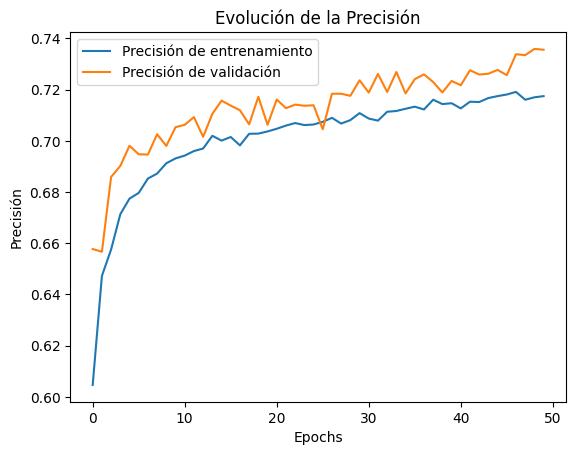

In [ ]:

# Entrenar el modelo
history = classifier_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=batch_size,
    validation_data=(X_test, y_test)
)

# --- Visualizar resultados ---
plt.plot(history.history["accuracy"], label="Precisión de entrenamiento")
plt.plot(history.history["val_accuracy"], label="Precisión de validación")
plt.title("Evolución de la Precisión")
plt.xlabel("Epochs")
plt.ylabel("Precisión")
plt.legend()
plt.show()


In [ ]:
classifier_model.save(r'C:\Users\mstor\Downloads\Dataset\mi_modelo_clasificador_ngrams.keras', include_optimizer=True, save_format='tf')

# Guardar el tokenizer
import pickle

with open(r'C:\Users\mstor\Downloads\Dataset\history_clasificador_ngrams.pickle', 'wb') as f:
    pickle.dump(history.history, f)

with open(r'C:\Users\mstor\Downloads\Dataset\optimizer_clasificador_ngrams.pickle', 'wb') as f:
    pickle.dump(classifier_model.optimizer, f)

In [ ]:
!pip install --upgrade numpy
import numpy as np

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 72.5 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pytensor 2.27.1 requires numpy<2,>=1.17.0, but you have numpy 2.2.3 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.3 which is incompatible.
numba 0.61.0 requires numpy<2.2,>=1.24, but you have numpy 2.2.3 which is incompatible.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.2.3 which is incompatible.
thinc 8.2.5 requires numpy<2.0.0,>=1.19.0; python_version >= "3.9", but you have numpy 2.2.3 which is incompatible.
langchain 0.3.19 requires numpy<2

In [ ]:
import pandas as pd

df = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/Trabajo Fin de Estudios/Dataset/mi_dataframe_ngrams_con_latente.pkl')

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split

X = np.vstack(df['representacion_latente'].values)
y = df['label'].values  # Obtener la columna 'label' como un array NumPy

# 2. Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # Ajustar test_size y random_state según sea necesario

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import itertools

# 1. Carga el modelo
classifier_model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Trabajo Fin de Estudios/Dataset/mi_modelo_clasificador_ngrams.keras')


In [ ]:
# Cargar el historial de entrenamiento

import pickle

with open('/content/drive/MyDrive/Colab Notebooks/Trabajo Fin de Estudios/Dataset/history_clasificador_ngrams.pickle', 'rb') as f:
    history = pickle.load(f)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import itertools
import matplotlib.ticker as mtick

In [ ]:
y_pred = classifier_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [ ]:

from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred_classes, target_names=['0 Humano', '1 IA'], output_dict=True)
print(classification_report(y_test, y_pred_classes, target_names=['0 Humano', '1 IA']))

              precision    recall  f1-score   support

    0 Humano       0.72      0.76      0.74      7979
        1 IA       0.75      0.71      0.73      8021

    accuracy                           0.74     16000
   macro avg       0.74      0.74      0.74     16000
weighted avg       0.74      0.74      0.74     16000



In [ ]:
cm = confusion_matrix(y_test, y_pred_classes)

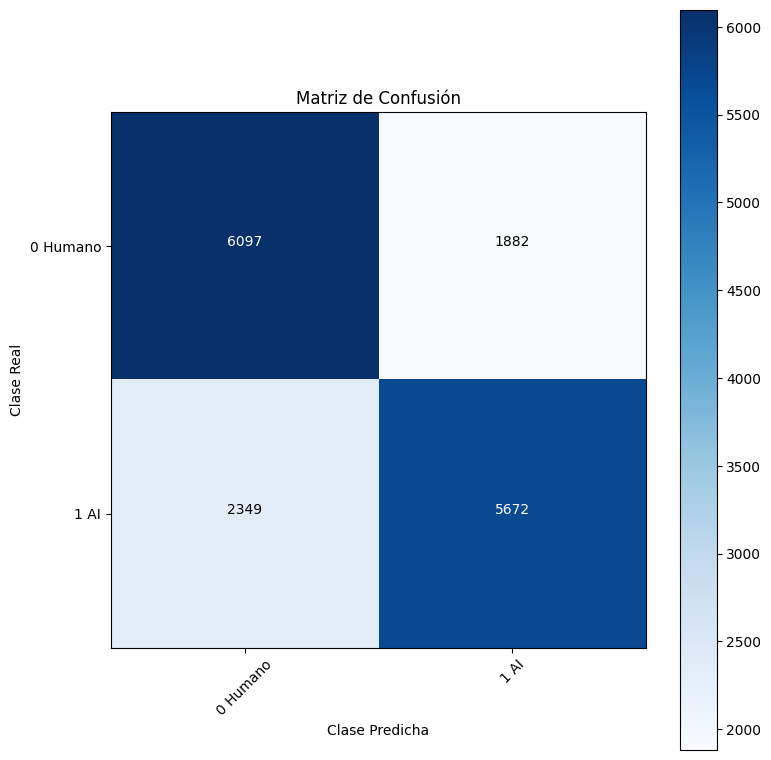

In [ ]:
# Etiquetas de tus clases
classes = ['0 Humano', '1 AI']  # ¡Aquí defines tus etiquetas!

plt.figure(figsize=(8, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matriz de Confusión')
plt.colorbar()
tick_marks = np.arange(len(classes))  # Reemplaza 'classes' con las etiquetas de tus clases
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Real')
plt.tight_layout()

# Añade números dentro de la matriz
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > cm.max() / 2. else "black")

plt.show()

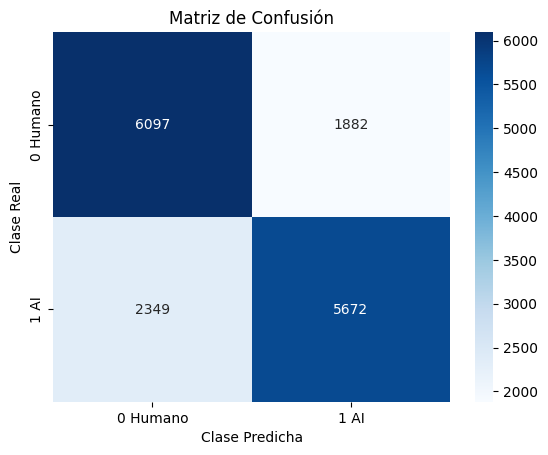

In [ ]:

import seaborn as sns

# b) Usando Seaborn
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Real')
plt.title('Matriz de Confusión')
plt.show()

In [ ]:
# Imprime las claves del diccionario para inspeccionarlas
print(report['0 Humano'].keys()) # Imprime las claves para la clase 0 Humano
print(report['1 IA'].keys()) # Imprime las claves para la clase 1 IA


dict_keys(['precision', 'recall', 'f1-score', 'support'])
dict_keys(['precision', 'recall', 'f1-score', 'support'])


In [ ]:
# Extraer accuracy del reporte
accuracy = report['accuracy']

data = {
    'Métrica': ['Precisión', 'Recall', 'F1-score'],
    '0 Humano': [report['0 Humano']['precision'], report['0 Humano']['recall'], report['0 Humano']['f1-score']],
    '1 IA': [report['1 IA']['precision'], report['1 IA']['recall'], report['1 IA']['f1-score']]
}
df = pd.DataFrame(data)

df_melted = pd.melt(df, id_vars=['Métrica'], var_name='Clase', value_name='Valor')


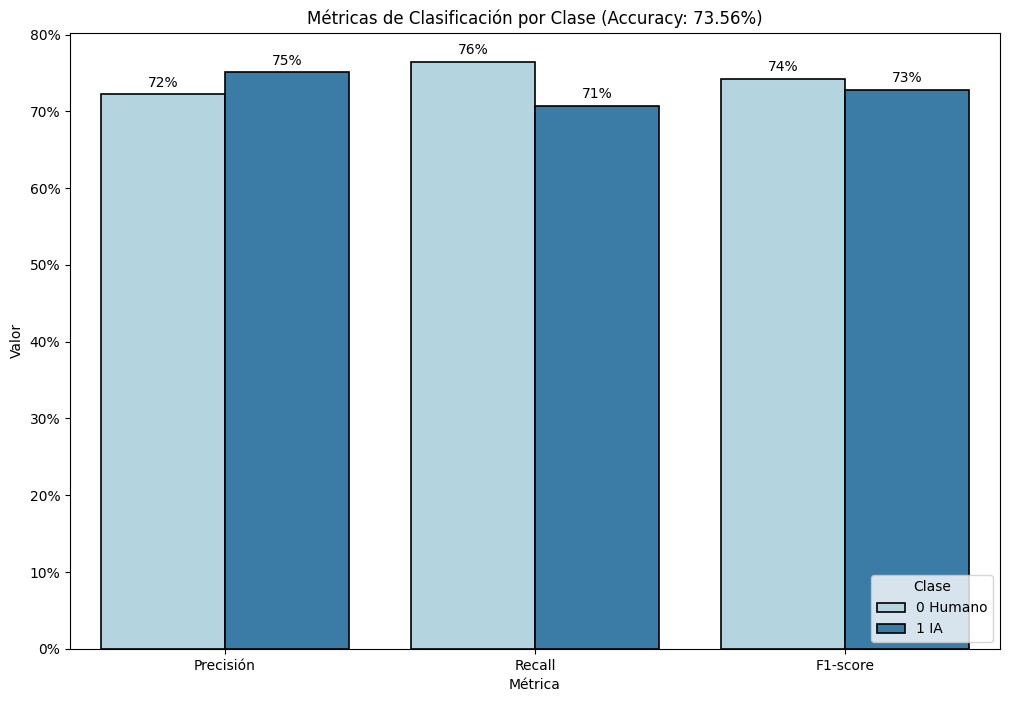

In [ ]:


plt.figure(figsize=(12, 8))  # Aumentar el tamaño del gráfico para mayor claridad

# Definir paleta de colores personalizada
colores = ["#ADD8E6", "#2980B9"]  # Azul pastel claro y azul más oscuro e intenso

ax = sns.barplot(x='Métrica', y='Valor', hue='Clase', data=df_melted, palette=colores, edgecolor='black', linewidth=1.2)

# Añadir etiquetas de porcentaje encima de cada barra
for p in ax.patches:
    height = p.get_height()
    # Mostrar etiqueta solo si el valor es mayor que 1%
    if height > 0.01:
        ax.text(p.get_x() + p.get_width()/2., height + 0.01, '{:.0%}'.format(height), ha="center")

# Formatear eje y como porcentaje
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

# Mover la leyenda abajo a la derecha
plt.legend(loc='lower right', title='Clase')

plt.title(f'Métricas de Clasificación por Clase (Accuracy: {accuracy:.2%})')
plt.xlabel('Métrica')
plt.ylabel('Valor')
plt.show()